<a href="https://colab.research.google.com/github/OlegV12/Neural/blob/Lesson_5/Lesson_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Практическое задание

<ol>
    <li>Попробуйте обучить нейронную сеть LSTM на любом другом датасете (любимый временной ряд, текст на русском (другом языке) как генератор или классификатор, или прилагаемый набор airline-passengers - пасажиропоток для авиалиний). Опишите, какой результата вы получили? Что помогло вам улучшить ее точность?

    
<li>*Попробуйте на numpy реализовать нейронную сеть архитектуры LSTM</li>
<li>*Предложите свои варианты решения проблемы исчезающего градиента в RNN</li>
</ol>

In [1]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import datetime
from keras.layers import Dense, Activation
from keras.layers.recurrent import SimpleRNN, LSTM, GRU
from keras.models import Sequential
import IPython


In [2]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [3]:
df = pd.read_csv('/gdrive/My Drive/Colab Notebooks/Neural Net/airline-passengers.csv')

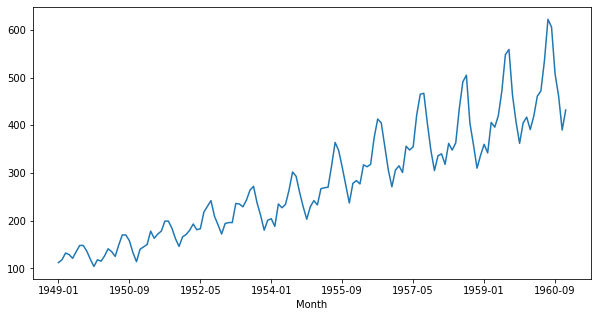

In [4]:
pd.Series(df['Passengers'].values, index=df['Month']).plot(figsize=(10, 5))

plt.show()

In [5]:
df['Month'] = pd.to_datetime(df['Month'], format="%Y/%m")

In [6]:
df['month_num'] = df['Month'].dt.month

In [7]:
df.drop(['Month'], axis=1, inplace=True)

In [8]:
df

,Passengers,month_num
0,112,1
1,118,2
2,132,3
3,129,4
4,121,5
...,...,...
139,606,8
140,508,9
141,461,10
142,390,11


In [9]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [10]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])
    

  def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
      labels = tf.stack(
          [labels[:, :, self.column_indices[name]] for name in self.label_columns],
          axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels



  def plot(self, model=None, plot_col='Passengers', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
      plt.subplot(max_n, 1, n+1)
      plt.ylabel(f'{plot_col}')
      plt.plot(self.input_indices, inputs[n, :, plot_col_index],
              label='Inputs', marker='.', zorder=-10)

      if self.label_columns:
        label_col_index = self.label_columns_indices.get(plot_col, None)
      else:
        label_col_index = plot_col_index

      if label_col_index is None:
        continue

      plt.scatter(self.label_indices, labels[n, :, label_col_index],
                  edgecolors='k', label='Labels', c='#2ca02c', s=64)
      if model is not None:
        predictions = model(inputs)
        plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                    marker='X', edgecolors='k', label='Predictions',
                    c='#ff7f0e', s=64)

      if n == 0:
        plt.legend()

    plt.xlabel('Month')


  def make_dataset(self, data):
      data = np.array(data, dtype=np.float32)
      ds = tf.keras.utils.timeseries_dataset_from_array(
          data=data,
          targets=None,
          sequence_length=self.total_window_size,
          sequence_stride=1,
          shuffle=True,
          batch_size=10,)

      ds = ds.map(self.split_window)

      return ds


  @property
  def train(self):
      return self.make_dataset(self.train_df)

  @property
  def val(self):
      return self.make_dataset(self.val_df)

  @property
  def test(self):
      return self.make_dataset(self.test_df)

  @property
  def example(self):
      """Get and cache an example batch of `inputs, labels` for plotting."""
      result = getattr(self, '_example', None)
      if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
      return result

In [15]:
MAX_EPOCHS = 30

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [16]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.GRU(124, return_sequences=True, input_shape=(6, 2), activation='linear'),
    tf.keras.layers.Dense(units=512, activation='linear'),

    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1, activation='linear')
])

In [17]:
wide_window = WindowGenerator(
    input_width=6, label_width=6, shift=1,
    label_columns=['Passengers'])

wide_window

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [1 2 3 4 5 6]
Label column name(s): ['Passengers']

In [18]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (10, 6, 2)
Output shape: (10, 6, 1)


In [19]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance = {}
performance = {}
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

3/3 [==============================] - 0s 6ms/step - loss: 2119.1160 - mean_absolute_error: 38.8548


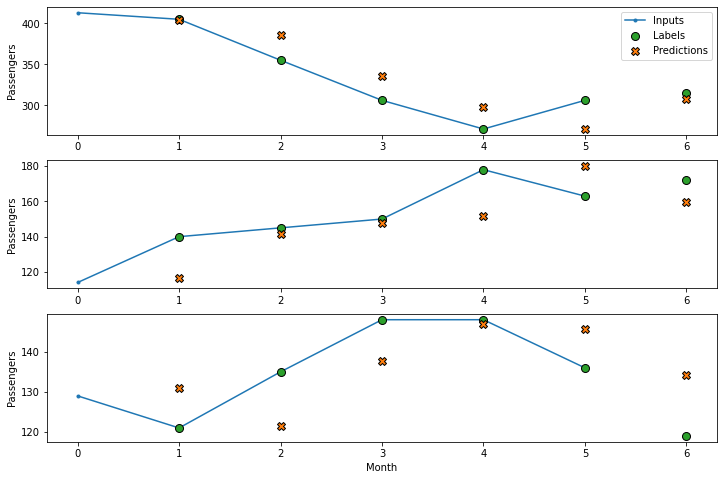

In [20]:
wide_window.plot(lstm_model,)

Попробуем предсказания на год вперед

In [21]:
lstm_model1 = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.GRU(124, return_sequences=True, input_shape=(12, 2), activation='linear'),
    tf.keras.layers.Dense(units=512, activation='linear'),

    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1, activation='linear')
])


In [22]:
wide_window = WindowGenerator(
    input_width=12, label_width=12, shift=1,
    label_columns=['Passengers'])

wide_window

Total window size: 13
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12]
Label column name(s): ['Passengers']

In [23]:
history = compile_and_fit(lstm_model1, wide_window)

IPython.display.clear_output()
val_performance = {}
performance = {}
val_performance['LSTM'] = lstm_model1.evaluate(wide_window.val)
performance['LSTM'] = lstm_model1.evaluate(wide_window.test, verbose=0)

2/2 [==============================] - 0s 8ms/step - loss: 1667.9934 - mean_absolute_error: 32.9753


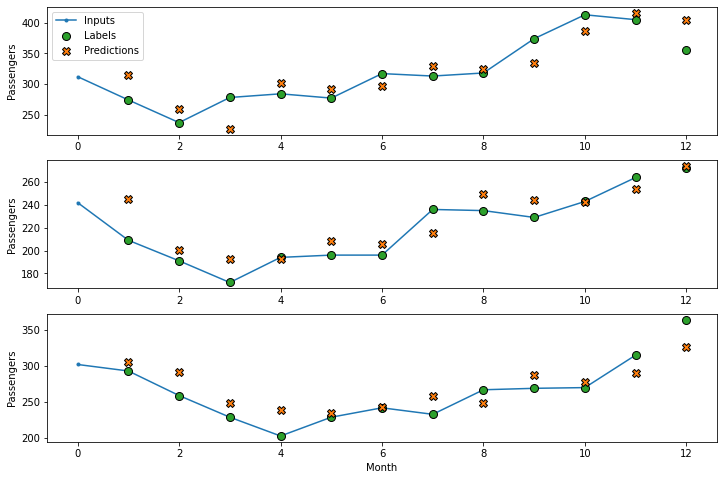

In [24]:
wide_window.plot(lstm_model1,)

Получили немного лучшие реультаты